# The Business Problem

You work for a small bank and are responsible for determining if customers are creditworthy to give a loan to. Your team typically gets 200 loan applications per week and approves them by hand.

Due to a financial scandal that hit a competitive bank last week, you suddenly have an influx of new people applying for loans for your bank instead of the other bank in your city. All of a sudden you have nearly 500 loan applications to process this week!

Your manager sees this new influx as a great opportunity and wants you to figure out how to process all of these loan applications within one week.

Fortunately for you, you just completed a course in classification modeling and know how to systematically evaluate the creditworthiness of these new loan applicants.

For this project, you will analyze the business problem using the Problem Solving Framework and provide a list of creditworthy customers to your manager in the next two days.

You have the following information to work with:
1. Data on all past applications
2. The list of customers that need to be processed in the next few days

# Data

`credit-data-training.xlsx` - This file contains all credit approvals from your past loan applicants the bank has ever completed.

`customers-to-score.xlsx` - This is the new set of customers that you need to score on the classification model you will create.

---

# Import

In [1]:
import seaborn as sns
sns.set()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import missingno as msno

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, Imputer, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, auc

from xgboost import XGBClassifier, plot_importance

In [3]:
def my_plot_importance(booster, figsize, **kwargs):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [4]:
data = pd.read_excel('data/credit-data-training.xlsx')
data.shape

(500, 20)

In [5]:
predict = pd.read_excel("data/customers-to-score.xlsx")
predict.shape

(500, 19)

In [6]:
# set target column variable
target = 'Credit-Application-Result'

In [7]:
random_seed = 1

---

# Examine target variable

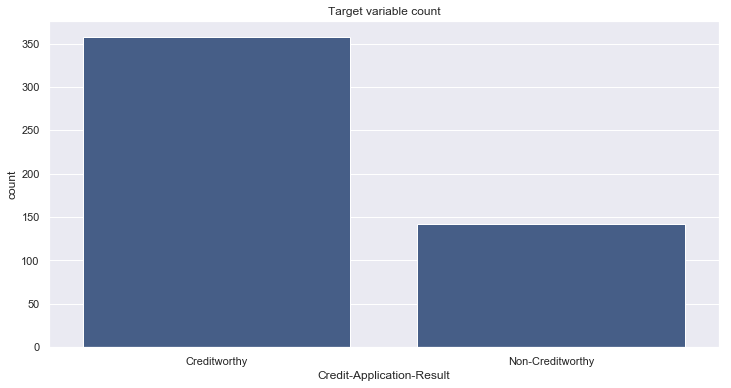

In [8]:
fig = plt.figure(figsize=(12,6))
sns.countplot(x=target, data=data, color=sns.xkcd_rgb["denim blue"])
plt.title('Target variable count')
plt.show()

From this information, we see this is an imbalanced class problem. There are far more creditworthy customers than non-creditworthy. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

According to the paper “The Relationship between Precision-Recall and ROC Curves” (Davis & Goadrich, 2006), the Precision-Recall AUC (PR AUC) should be used instead of the ROC AUC when it comes to imbalanced-class problems. The authors state that “A large number change in the number of false positives can lead to a small change in the false positive rate used in ROC analysis. Precision, on the other hand, by comparing false positives to true positives rather than true negatives, captures the effect of the large number of negative examples on the algorithm's performance.” We will use the ROC curve regardless, because this is given in the assignment.

---

# Missing values

Models such as XGBoost can handle missing values, but most algorithms cannot. Hence, we need to handle the missing values.

In [9]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
# Missing values statistics
missing_values = missing_values_table(predict)
missing_values.head(20)

Your selected dataframe has 19 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Our prediction set does not have any missing values.

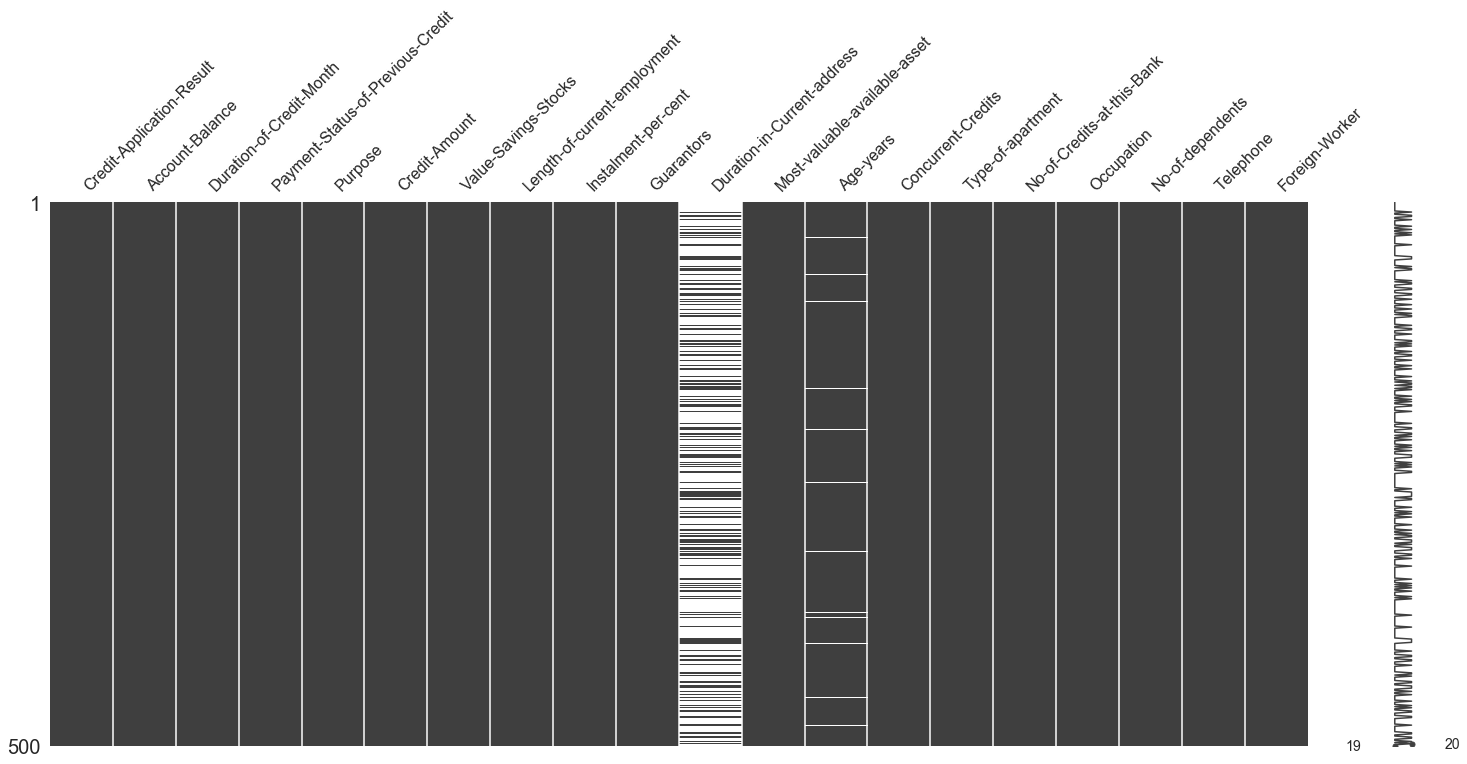

In [11]:
msno.matrix(data.sample(500))

In [12]:
# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(20)

Your selected dataframe has 20 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Duration-in-Current-address,344,68.8
Age-years,12,2.4


In our training set, `Age-years` has 12 missing values, while `Duration-in-Current-address` has 344, more than 50% of the total values!

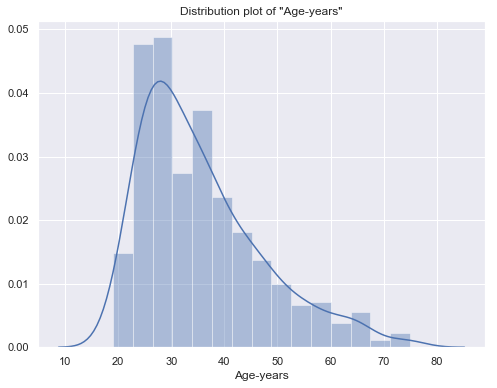

In [13]:
plt.figure(figsize = (8, 6))
ax = sns.distplot(data['Age-years'].dropna())
plt.title('Distribution plot of "Age-years"')
plt.show()

In [14]:
data['Age-years'].median()

33.0

For `Age-years` we will impute the values. Age is a type of numeric data that works great for an impute strategy. Imputing adds variance to our data, and we are better off than losing information by dropping the rows. Furthermore, imputation is a good approach when the dataset size is small, which is precisely our case. As you can see in above histogram, the age data is skewed. Hence, we will impute the missing values with the `median = 33`.

Since `Duration-in-Current-address` has 68.8% missing values of total values, it is decided to drop this column.

---

# EDA

In [15]:
# Number of each type of column
data.dtypes.value_counts()

object     9
int64      9
float64    2
dtype: int64

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method.

In [16]:
data.select_dtypes(include=['float', 'int']).describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Duration-of-Credit-Month,500.0,21.434000,12.307420,4.0,12.00,18.0,24.0,60.0
Credit-Amount,500.0,3199.980000,2831.386861,276.0,1357.25,2236.5,3941.5,18424.0
Instalment-per-cent,500.0,3.010000,1.113724,1.0,2.00,3.0,4.0,4.0
Duration-in-Current-address,156.0,2.660256,1.150017,1.0,2.00,2.0,4.0,4.0
Most-valuable-available-asset,500.0,2.360000,1.064268,1.0,1.00,3.0,3.0,4.0
Age-years,488.0,35.637295,11.501522,19.0,27.00,33.0,42.0,75.0
Type-of-apartment,500.0,1.928000,0.539814,1.0,2.00,2.0,2.0,3.0
Occupation,500.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
No-of-dependents,500.0,1.146000,0.353460,1.0,1.00,1.0,1.0,2.0
Telephone,500.0,1.400000,0.490389,1.0,1.00,1.0,2.0,2.0


`Instalment-per-cent`, `Most-valuable-available-asset`, `Type of apartment`, `No-of-dependents`, `Telephone` and `Foreign Worker` seem to be of categorical nature – however, in the project documentation it is asked to keep these as data type double to get consistent results for reviewers. Hence, we will not change the types.

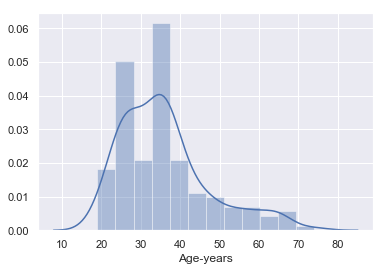

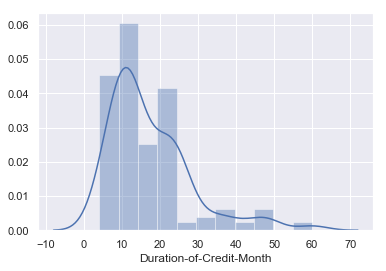

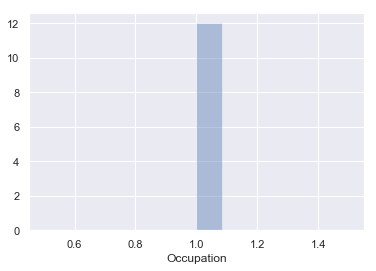

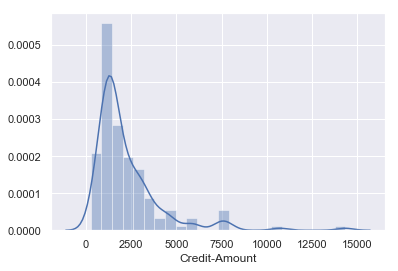

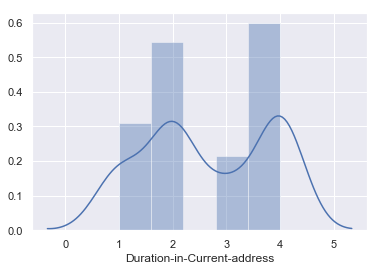

In [17]:
dropcols = ['Instalment-per-cent', 'Most-valuable-available-asset', 'Type-of-apartment',
           'No-of-dependents', 'Telephone', 'Foreign-Worker']

numcols = set(data.select_dtypes(include=['float', 'int']).columns.tolist()) - set(dropcols)

for col in numcols:
    sns.distplot(data[np.isfinite(data['Duration-in-Current-address'])].fillna((data['Age-years'].mean())).loc[:, col])
    plt.show()

`Occupation` takes in only one value, which doesn't add any value, so we will drop it.

In [18]:
data.select_dtypes(include=['object', 'category']).describe(include='all').T

,count,unique,top,freq
Credit-Application-Result,500,2,Creditworthy,358
Account-Balance,500,2,No Account,262
Payment-Status-of-Previous-Credit,500,3,Paid Up,260
Purpose,500,4,Home Related,355
Value-Savings-Stocks,500,3,None,298
Length-of-current-employment,500,3,< 1yr,279
Guarantors,500,2,None,457
Concurrent-Credits,500,1,Other Banks/Depts,500
No-of-Credits-at-this-Bank,500,2,1,320


`Concurrent-Credits` takes in only one value, which doesn't add any value, so we will drop it.

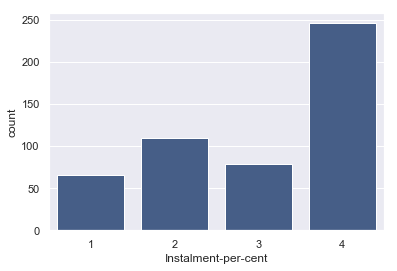

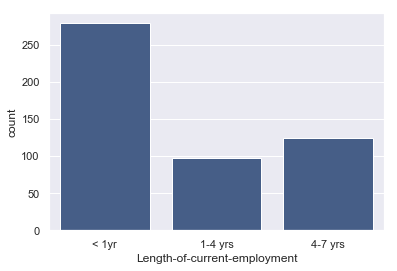

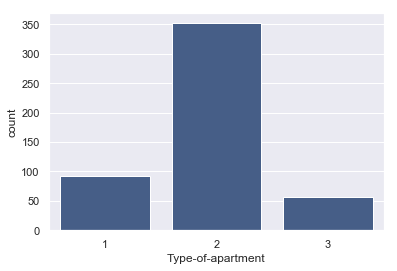

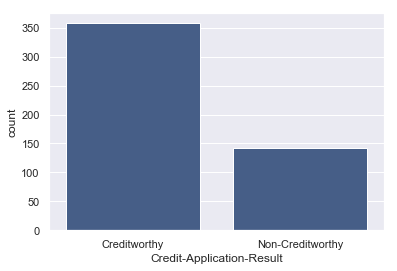

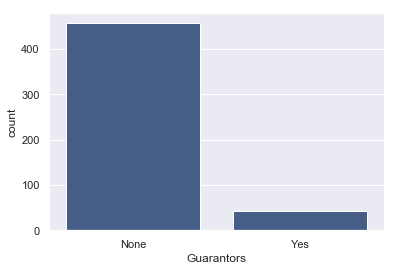

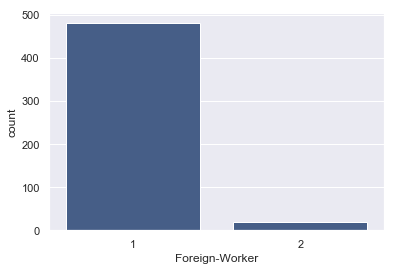

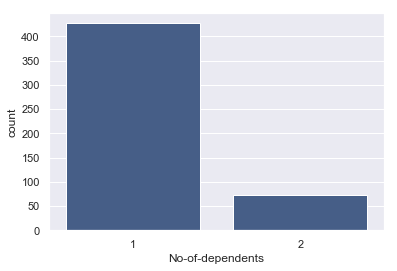

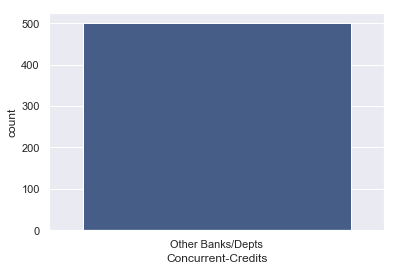

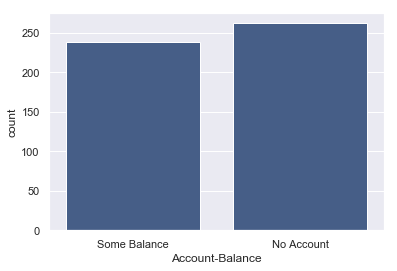

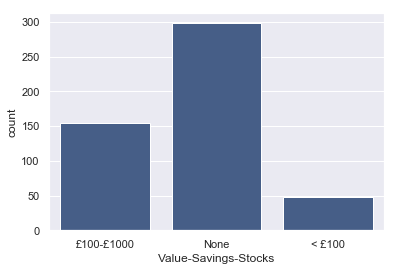

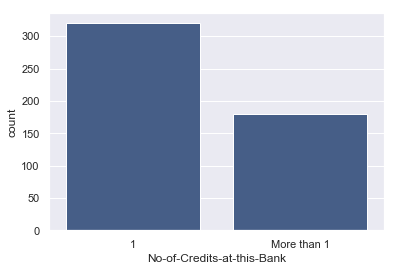

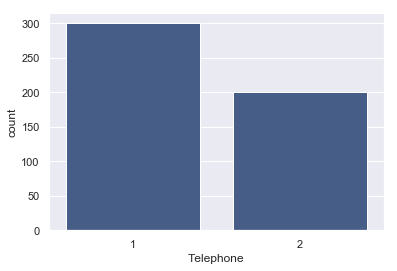

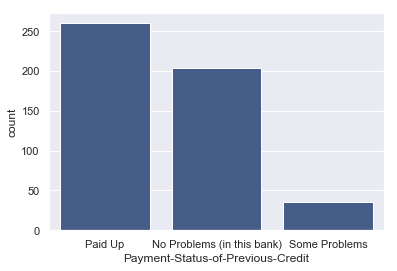

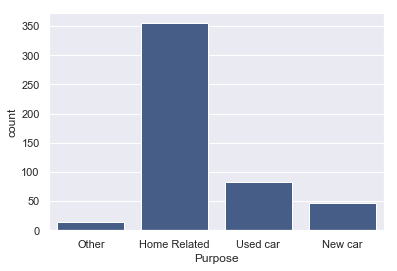

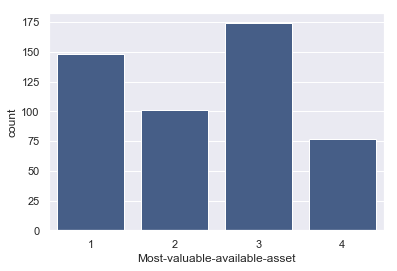

In [19]:
catcols = set(data.columns) - set(numcols)

for col in catcols:
    sns.countplot(data[col], color=sns.xkcd_rgb["denim blue"])
    plt.show()

`Guarantors`, `Foreign-Worker` and `No-of-Dependents` seem to have low variability, since more than 80% of the data is skewed towards a value. We will remove these to avoid skewing in our model due to imbalance.

`Telephone` might be useful to collect debts to make a customer more creditworthy, but otherwise there is no logical reason for including it in our model. Following Udacity's recommendation, we will hence drop this variable too.

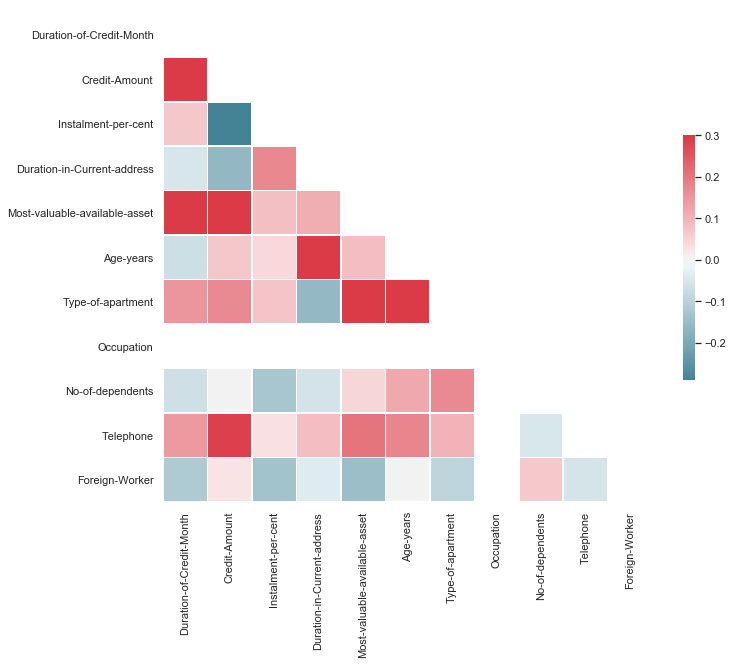

In [20]:
corr = data[data.select_dtypes(include=['float', 'int']).columns.tolist()].corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Preprocessing

In [21]:
# Impute data
data['Age-years'] = data['Age-years'].fillna((data['Age-years'].mean()))

# Drop columns
dropcols = ['Concurrent-Credits', 'Duration-in-Current-address', 'Occupation', 'Guarantors',
            'Foreign-Worker', 'No-of-dependents', 'Telephone']

data = data.drop(dropcols, axis=1)
data.shape

(500, 13)

# Encode categorical variables

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but **for more than 2 unique categories, one-hot encoding is the safe option**.

Stackoverflow discussion: https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

For any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [22]:
data[target] = data[target].replace('Creditworthy', 1)
data[target] = data[target].replace('Non-Creditworthy', 0)

In [23]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            predict[col] = le.transform(predict[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

2 columns were label encoded.


In [24]:
# one-hot encoding of categorical variables
data = pd.get_dummies(data)
predict = pd.get_dummies(predict)

print('Training Features shape: ', data.shape)
print('Predict Features shape: ', predict.shape)

Training Features shape:  (500, 22)
Predict Features shape:  (500, 28)


# Align train and predict data

One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes.

In [25]:
train_labels = data[target]

# Align the training and testing data, keep only columns present in both dataframes
data, predict = data.align(predict, join = 'inner', axis = 1)

# Add the target back in
data[target] = train_labels

print('Training Features shape: ', data.shape)
print('Testing Features shape: ', predict.shape)

Training Features shape:  (500, 21)
Testing Features shape:  (500, 20)


# Correlations

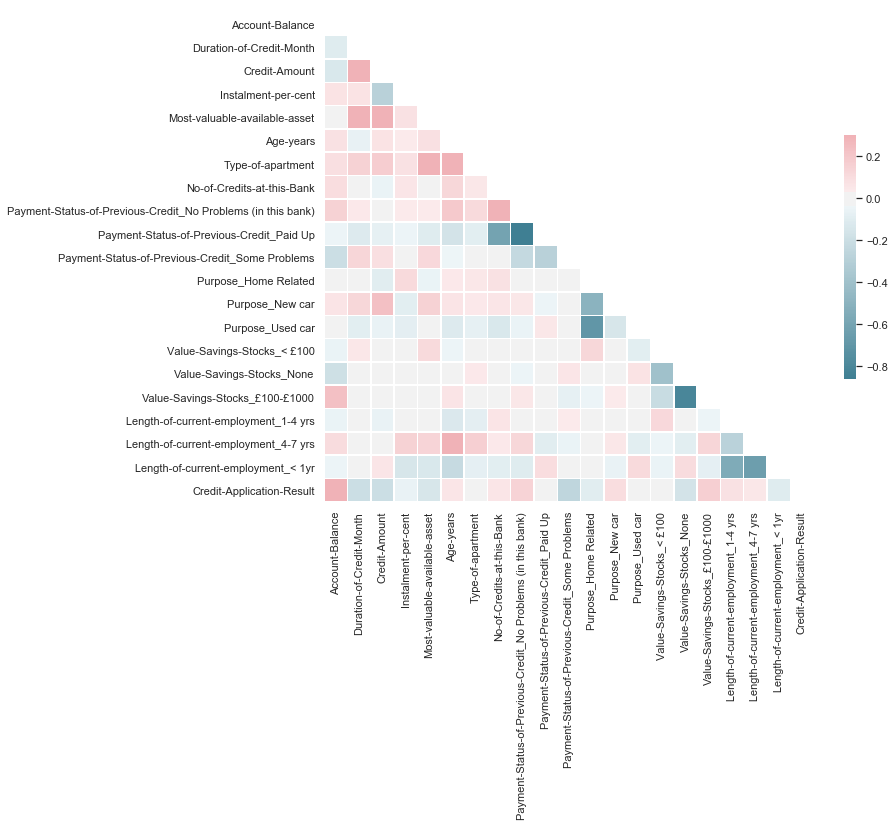

In [26]:
corr = data.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

None of the variables are highly correlated with one another.

In [27]:
# Find correlations with the target and sort
data.corr()[target].sort_values(ascending=False)

Credit-Application-Result                                       1.000000
Account-Balance                                                 0.316080
Value-Savings-Stocks_£100-£1000                                 0.160782
Payment-Status-of-Previous-Credit_No Problems (in this bank)    0.143815
Purpose_New car                                                 0.096477
Length-of-current-employment_1-4 yrs                            0.073444
No-of-Credits-at-this-Bank                                      0.056549
Age-years                                                       0.056459
Length-of-current-employment_4-7 yrs                            0.053569
Purpose_Used car                                                0.030658
Value-Savings-Stocks_< £100                                     0.024571
Payment-Status-of-Previous-Credit_Paid Up                      -0.010298
Type-of-apartment                                              -0.026516
Instalment-per-cent                                

The most positive correlated variables are
* Account-Balance
* Value-Savings-Stocks_£100-£1000
* Payment-Status-of-Previous-Credit_No Problems (in this bank)

This makes sense, as the higher the account balance, the more creditworthy a customer could be. If the customer had no problems in this bank, thez would also seem more creditworthy.

The most negative correlated variables are 
* Payment-Status-of-Previous-Credit_Some Problems
* Duration-of-Credit-Month
* Credit-Amount

This also makes sense. if the payment of the previous credit posed some problems, and the larger a credit amount is, a customer may be not creditworthy.

---

# Train model

## Prepare for training

In [28]:
# Drop the target from the training data
if target in data:
    train = data.drop([target], axis=1)
else:
    train = data.copy()

In [29]:
# Feature names
features = list(train.columns)

In [30]:
# Copy of the testing data
test = predict.copy()

Because of the error `ValueError: feature_names may not contain [, ] or <` we will rename the columns:

In [31]:
features_rename = ['Account-Balance',
                     'Duration-of-Credit-Month',
                     'Credit-Amount',
                     'Instalment-per-cent',
                     'Most-valuable-available-asset',
                     'Age-years',
                     'Type-of-apartment',
                     'No-of-Credits-at-this-Bank',
                     'Payment-Status-of-Previous-Credit_No Problems in this bank',
                     'Payment-Status-of-Previous-Credit_Paid Up',
                     'Payment-Status-of-Previous-Credit_Some Problems',
                     'Purpose_Home Related',
                     'Purpose_New car',
                     'Purpose_Used car',
                     'Value-Savings-Stocks_less 100',
                     'Value-Savings-Stocks_None',
                     'Value-Savings-Stocks_100-1000',
                     'Length-of-current-employment_1-4 yrs',
                     'Length-of-current-employment_4-7 yrs',
                     'Length-of-current-employment_less 1yr']

In [32]:
train.columns = features_rename
test.columns = features_rename

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, data[target], test_size=0.3, random_state=random_seed)

In [34]:
# normalize the data
scaler = StandardScaler().fit(X_train)
X_train_stdscaled = scaler.transform(X_train)
X_test_stdscaled = scaler.transform(X_test)

In [35]:
# normalize the data
scaler = MinMaxScaler().fit(X_train)
X_train_mmscaled = scaler.transform(X_train)
X_test_mmscaled = scaler.transform(X_test)

# Logistic Regression

In [ ]:
logreg = LogisticRegression()

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]
}

In [ ]:
CV_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 5)
CV_logreg.fit(X_train, y_train)

In [ ]:
CV_logreg.best_params_

# non-scaled: {'C': 1, 'penalty': 'l2'}
# std-scaled: {'C': 0.003, 'penalty': 'l2'}
# mm-scaled: {'C': 1, 'penalty': 'l2'}

In [36]:
logreg = LogisticRegression(C=1,
                            penalty='l2',
                            random_state=random_seed)

In [37]:
logreg_fit = logreg.fit(X_train, y_train)
logreg_pred = logreg_fit.predict(X_test)

In [38]:
accuracy_score(y_test,logreg_pred)

# non-scaled: 0.77
# std-scaled: 0.77
# mm-scaled: 0.77

0.7666666666666667

In [39]:
print('Misclassified samples: %d' % (y_test != logreg_pred).sum())

Misclassified samples: 35


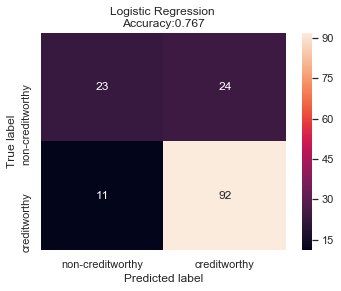

In [40]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, logreg_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['non-creditworthy','creditworthy'], 
                     columns = ['non-creditworthy','creditworthy'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
print(classification_report(y_test,logreg_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.68      0.49      0.57        47
    Creditworthy       0.79      0.89      0.84       103

     avg / total       0.76      0.77      0.75       150



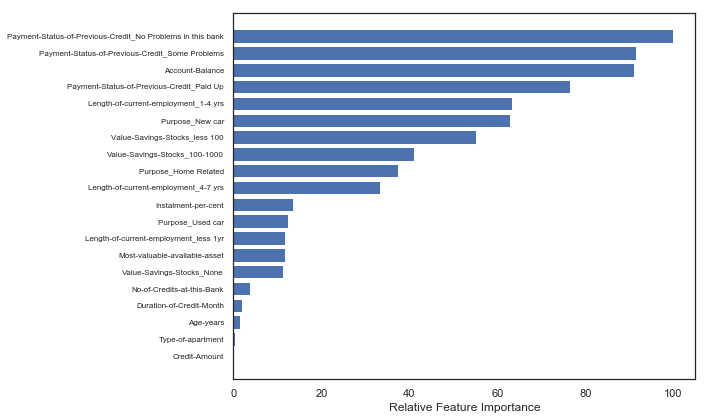

In [42]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize = (10, 6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

# Decision Tree

In [43]:
dt = DecisionTreeClassifier()

In [44]:
param_grid = {
    'criterion':('gini', 'entropy'),
    'min_samples_split':[2,3,4,5],
    'max_depth':[9,10,11,12],
    'class_weight':('balanced', None),
    'presort':(False,True),
}

In [45]:
CV_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv= 5)
CV_dt.fit(X_train_mmscaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [9, 10, 11, 12], 'min_samples_split': [2, 3, 4, 5], 'presort': (False, True), 'criterion': ('gini', 'entropy'), 'class_weight': ('balanced', None)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
CV_dt.best_params_

# non-scaled: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2, 'presort': False}
# std-scaled: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2, 'presort': False}
# mm-scaled: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2, 'presort': True}

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 4,
 'presort': False}

In [47]:
dt = DecisionTreeClassifier(class_weight=None,
                            criterion='entropy',
                            max_depth=9,
                            min_samples_split=2,
                            presort=False,
                            random_state=random_seed)

In [48]:
dt_fit = dt.fit(X_train, y_train)
dt_pred = dt_fit.predict(X_test)

In [49]:
accuracy_score(y_test,dt_pred)

# non-scaled: 0.67
# std-scaled: 0.67
# mm-scaled: 0.67

0.6666666666666666

In [50]:
print('Misclassified samples: %d' % (y_test != dt_pred).sum())

Misclassified samples: 50


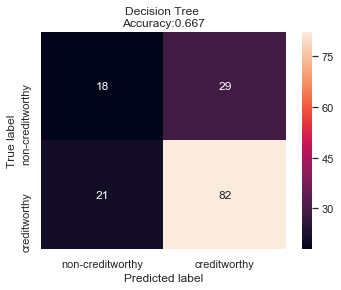

In [51]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, dt_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['non-creditworthy','creditworthy'], 
                     columns = ['non-creditworthy','creditworthy'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, dt_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [52]:
print(classification_report(y_test,dt_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.46      0.38      0.42        47
    Creditworthy       0.74      0.80      0.77       103

     avg / total       0.65      0.67      0.66       150



In [53]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

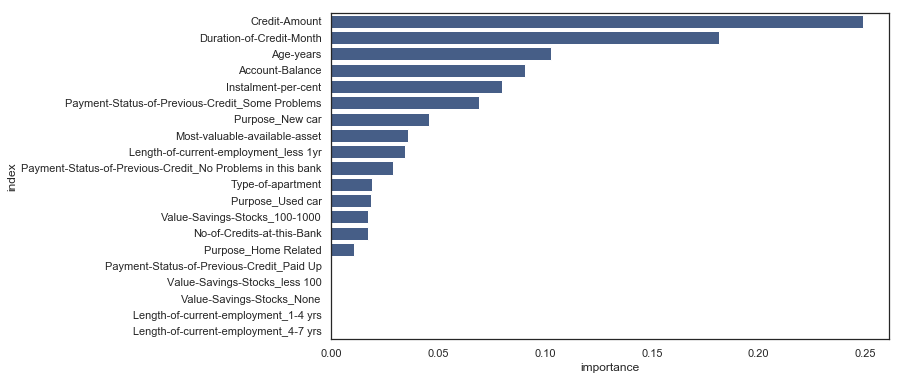

In [54]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='importance', y='index', data=feature_importances.reset_index(), color=sns.xkcd_rgb["denim blue"])
plt.show()

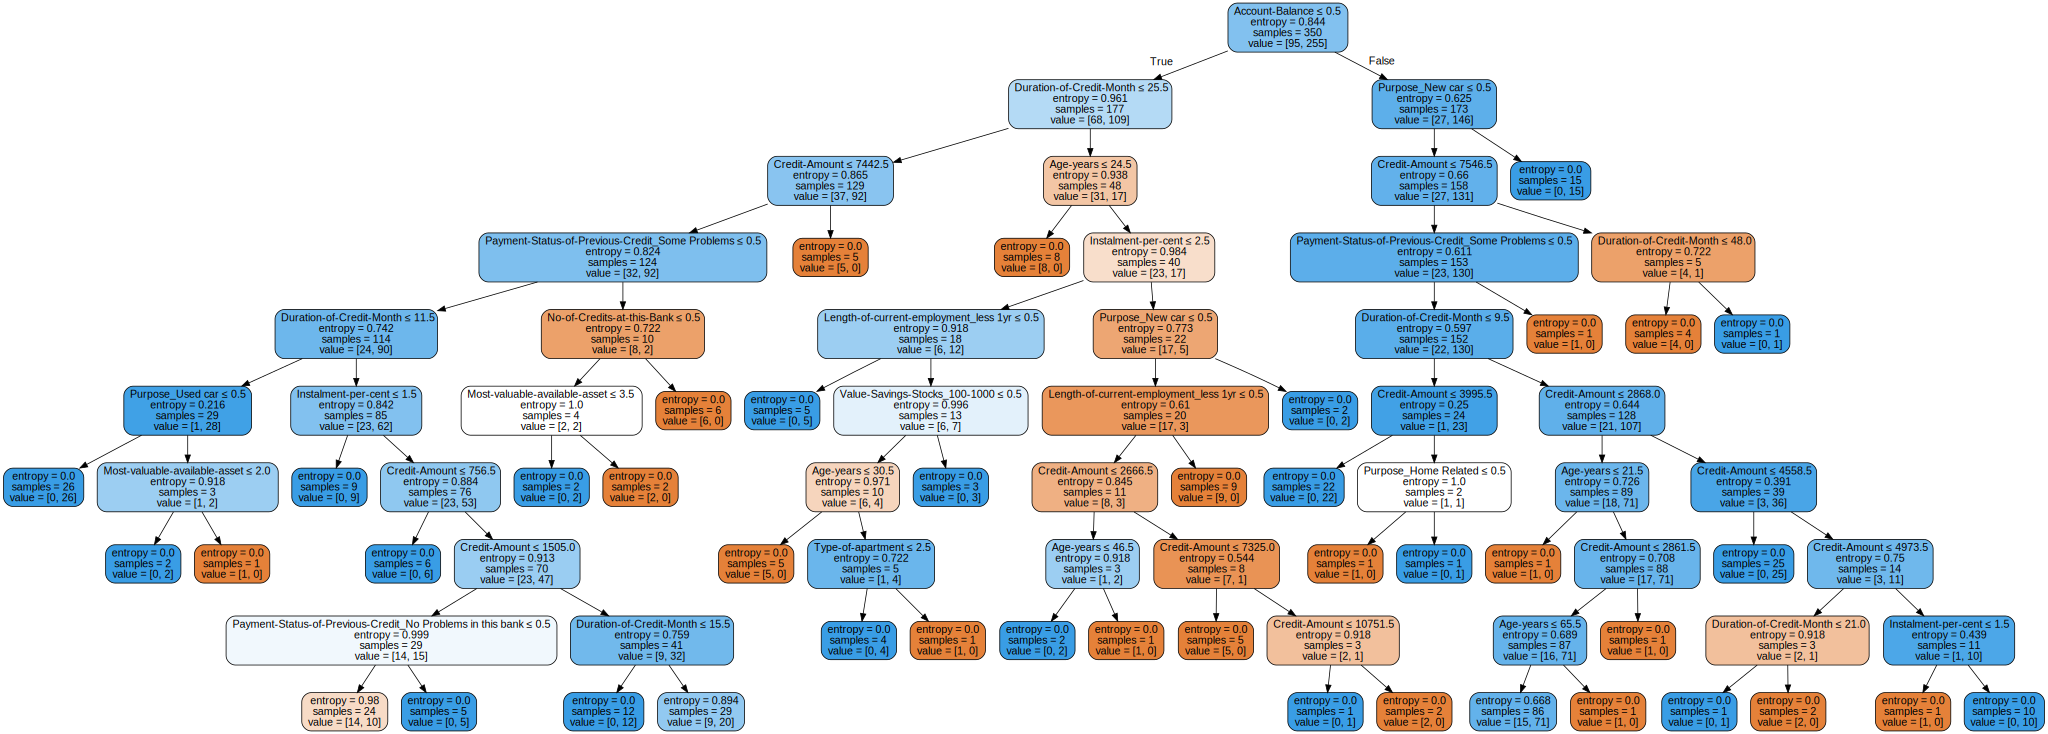

In [55]:
import graphviz
dot_data = export_graphviz(dt, out_file=None,
                           feature_names=X_test.columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Random Forest

In [56]:
rf = RandomForestClassifier()

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)

In [ ]:
CV_rf.best_params_

# non-scaled: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
# std-scaled: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
# mm-scaled: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}

In [57]:
rf = RandomForestClassifier(random_state=random_seed,
                            criterion='gini',
                            max_depth=7,
                            max_features='sqrt',
                            n_estimators=200)

In [58]:
rf_fit = rf.fit(X_train, y_train)
rf_pred = rf_fit.predict(X_test)

In [59]:
accuracy_score(y_test,rf_pred)

# non-scaled: 0.753
# std-scaled: 0.753
# mm-scaled: 0.753

0.7533333333333333

In [60]:
print('Misclassified samples: %d' % (y_test != rf_pred).sum())

Misclassified samples: 37


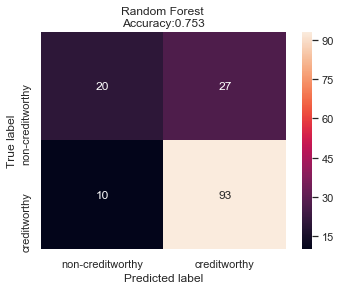

In [61]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, rf_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['non-creditworthy','creditworthy'], 
                     columns = ['non-creditworthy','creditworthy'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [62]:
print(classification_report(y_test,rf_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.67      0.43      0.52        47
    Creditworthy       0.78      0.90      0.83       103

     avg / total       0.74      0.75      0.74       150



In [63]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

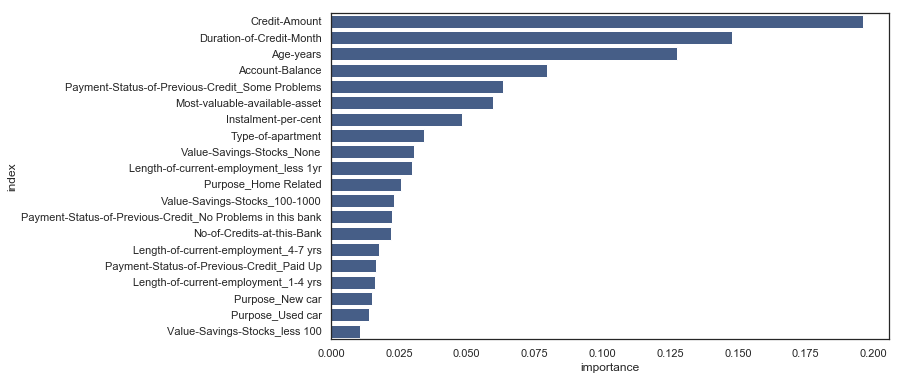

In [64]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='importance', y='index', data=feature_importances.reset_index(), color=sns.xkcd_rgb["denim blue"])
plt.show()

# Gradient Boost

In [65]:
gb = GradientBoostingClassifier()

In [ ]:
# A parameter grid for GBClassifier
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [ ]:
CV_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv= 5)
CV_gb.fit(X_train, y_train)

In [ ]:
# non-scaled: 
'''{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.390909090909091,
 'n_estimators': 10,
 'subsample': 0.95}'''
# std-scaled: 
'''{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.17272727272727273,
 'n_estimators': 10,
 'subsample': 1.0}'''
# mm-scaled: 
'''{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.13636363636363638,
 'n_estimators': 10,
 'subsample': 0.9}'''

CV_gb.best_params_

In [66]:
gb = GradientBoostingClassifier(loss='deviance',
                                learning_rate=0.2,
                                min_samples_split=0.390909090909091,
                                min_samples_leaf=0.1,
                                max_depth=3,
                                max_features='sqrt',
                                criterion='friedman_mse',
                                subsample=0.95,
                                n_estimators=10,
                                random_state=random_seed)
gb_fit = gb.fit(X_train, y_train)
gb_pred = gb_fit.predict(X_test)

In [67]:
accuracy_score(y_test,gb_pred)

# non-scaled: 0.733
# std-scaled: 0.707
# mm-scaled: 0.727

0.7333333333333333

In [68]:
print('Misclassified samples: %d' % (y_test != gb_pred).sum())

Misclassified samples: 40


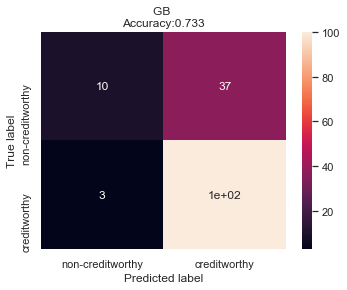

In [69]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, gb_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['non-creditworthy','creditworthy'], 
                     columns = ['non-creditworthy','creditworthy'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('GB \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [70]:
print(classification_report(y_test,gb_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.77      0.21      0.33        47
    Creditworthy       0.73      0.97      0.83       103

     avg / total       0.74      0.73      0.68       150



In [71]:
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

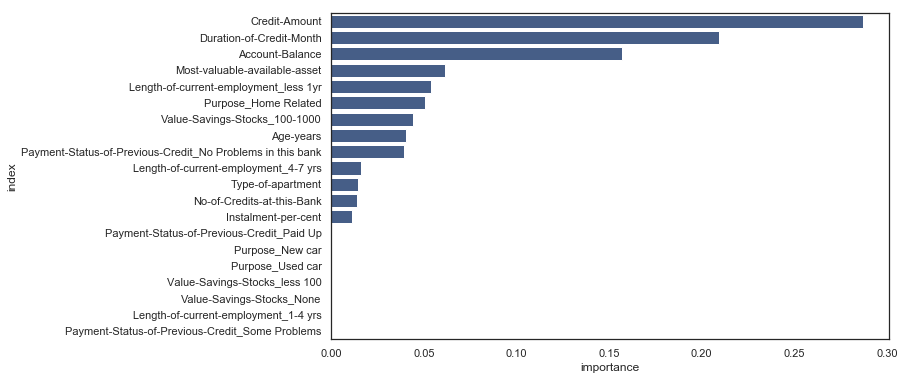

In [72]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='importance', y='index', data=feature_importances.reset_index(), color=sns.xkcd_rgb["denim blue"])
plt.show()

# XGBoost

In [73]:
xgb = XGBClassifier()

In [77]:
xgb = XGBClassifier(seed=random_seed,
                    colsample_bytree=0.8,
                    gamma=1,
                    max_depth=3,
                    min_child_weight=10,
                    subsample=0.6)
xgb_fit = xgb.fit(X_train, y_train)
xgb_pred = xgb_fit.predict(X_test)

/Users/Claudi/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [78]:
accuracy_score(y_test,xgb_pred)

# non-scaled: 0.8
# std-scaled: 0.8
# mm-scaled: 0.8

0.8

In [79]:
print('Misclassified samples: %d' % (y_test != xgb_pred).sum())

Misclassified samples: 30


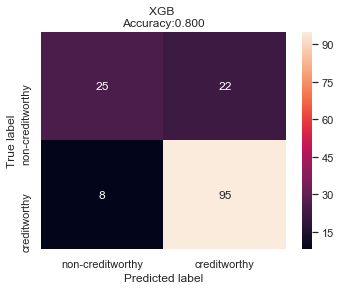

In [80]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, xgb_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['non-creditworthy','creditworthy'], 
                     columns = ['non-creditworthy','creditworthy'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('XGB \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, xgb_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [81]:
print(classification_report(y_test,xgb_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.76      0.53      0.62        47
    Creditworthy       0.81      0.92      0.86       103

     avg / total       0.79      0.80      0.79       150



In [82]:
feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

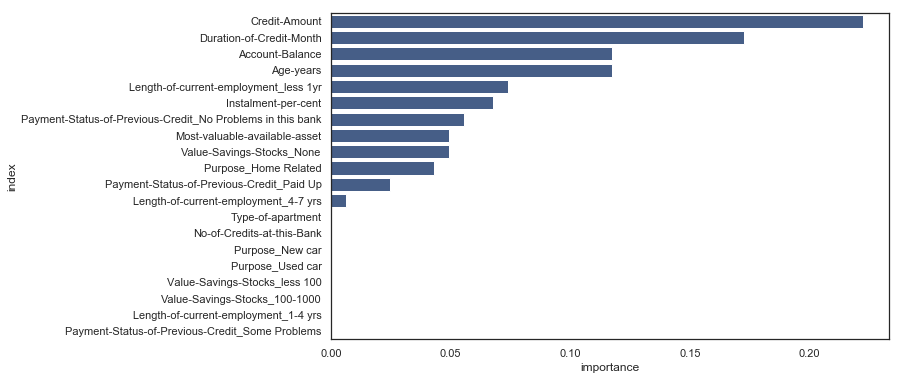

In [83]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='importance', y='index', data=feature_importances.reset_index(), color=sns.xkcd_rgb["denim blue"])
plt.show()

# Write Up

In [84]:
# model comparison ROC curve

ROC AUC LOGREG: 0.800
ROC AUC DT: 0.544
ROC AUC RF: 0.797
ROC AUC GB: 0.740
ROC AUC XGB: 0.807


<Figure size 432x288 with 0 Axes>

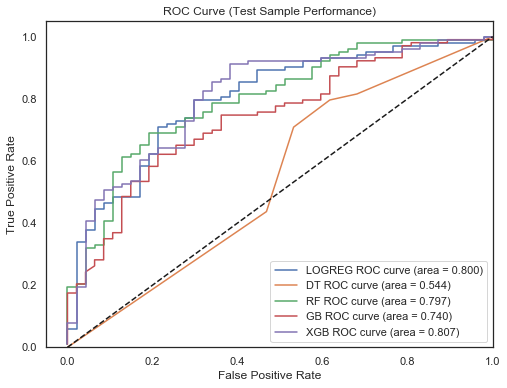

In [85]:
plt.clf()
plt.figure(figsize=(8,6))

# LOG REG
FPR, TPR, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
roc_auc = auc(FPR, TPR)
print ('ROC AUC LOGREG: %0.3f' % roc_auc )
plt.plot(FPR, TPR, label='LOGREG ROC curve (area = %0.3f)' % roc_auc)

# Decision Tree
FPR, TPR, _ = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
roc_auc = auc(FPR, TPR)
print ('ROC AUC DT: %0.3f' % roc_auc )
plt.plot(FPR, TPR, label='DT ROC curve (area = %0.3f)' % roc_auc)

# Random Forest
FPR, TPR, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(FPR, TPR)
print ('ROC AUC RF: %0.3f' % roc_auc )
plt.plot(FPR, TPR, label='RF ROC curve (area = %0.3f)' % roc_auc)

# Gradient Boosting
FPR, TPR, _ = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
roc_auc = auc(FPR, TPR)
print ('ROC AUC GB: %0.3f' % roc_auc )
plt.plot(FPR, TPR, label='GB ROC curve (area = %0.3f)' % roc_auc)

# XGB
FPR, TPR, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
roc_auc = auc(FPR, TPR)
print ('ROC AUC XGB: %0.3f' % roc_auc )
plt.plot(FPR, TPR, label='XGB ROC curve (area = %0.3f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc="lower right")
plt.show()

In [97]:
def final_pred(pred):
    print('Correct: {}'.format(pred.sum()))
    print('Ratio of Correct: {}'.format(pred.sum()/len(pred)))

In [99]:
final_pred(logreg_fit.predict(test))

Correct: 418
Ratio of Correct: 0.836


In [100]:
final_pred(dt_fit.predict(test))

Correct: 386
Ratio of Correct: 0.772


In [101]:
final_pred(rf_fit.predict(test))

Correct: 432
Ratio of Correct: 0.864


In [103]:
final_pred(gb_fit.predict(test))

Correct: 463
Ratio of Correct: 0.926


In [104]:
final_pred(xgb_fit.predict(test))

Correct: 425
Ratio of Correct: 0.85


/Users/Claudi/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
